### imports

In [1263]:
import math
import datetime
import pandas as pd
import numpy as np

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers

In [1264]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [1265]:
CLASSIFICATION_LABELS = ['Super Area', 'Carpet Area', 'Built Area']

In [1266]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [1267]:
def plot_value_array(i, predictions_array, true_label_array):
  plt.grid(False)
  plt.xticks([])
  # plt.yticks([])
  thisplot = plt.bar(range(len(CLASSIFICATION_LABELS)), predictions_array, color="#777777")
  plt.ylim([0, None])
  true_label = np.argmax(true_label_array)
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')
  return thisplot

In [1268]:
dataset = pd.read_csv("Formatted_Data.csv", low_memory=False)

In [1269]:
dataset.var()

BHK                 0.692650
Rent                0.877299
Size                0.502059
Super Area          0.249816
Carpet Area         0.249803
Built Area          0.000421
Mumbai              0.162894
Chennai             0.152524
Bangalore           0.151865
Hyderabad           0.149473
Delhi               0.111249
Kolkata             0.098239
Semi-Furnished      0.249392
Unfurnished         0.236226
Furnished           0.122776
Bachelors/Family    0.199118
Bachelors           0.144330
Family              0.089580
Bathroom            0.782396
dtype: float64

### training and test set

In [1270]:
training_set_size = int(len(dataset.index) * 0.65)
validation_set_size = int(len(dataset.index) * 0.05)
training_set = dataset[:training_set_size]
validation_set = dataset[training_set_size : training_set_size + validation_set_size]
test_set = dataset[training_set_size + validation_set_size:]

In [1271]:
features = training_set.copy()
labels = pd.concat([features.pop(x) for x in CLASSIFICATION_LABELS], axis=1)

In [1272]:
validation_features = validation_set.copy()
validation_labels = pd.concat([validation_features.pop(x) for x in CLASSIFICATION_LABELS], axis=1)

### compile and train model

In [1273]:
normalize = layers.Normalization()
normalize.adapt(features)
initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=0.03, seed=1)
model = tf.keras.Sequential([
  normalize,
  layers.Dense(128, name="one", activation='relu', kernel_initializer=initializer),
  layers.Dense(128, name="two", activation='relu', kernel_initializer=initializer),
  layers.Dense(128, name="three", activation='relu', kernel_initializer=initializer),
  layers.Dropout(0.2, name="dropout"),
  layers.Dense(len(CLASSIFICATION_LABELS), name="output", activation='softmax', kernel_initializer=initializer)
])

In [1274]:
model.compile(
    # optimizer='adam',
    # tf.keras.optimizers.Adam(
    #     learning_rate=0.001,
    #     beta_1=0.9,
    #     beta_2=0.999,
    #     epsilon=1e-07,
    #     amsgrad=False,
    #     name="Adam",
    # ),
    # optimizer=tf.keras.optimizers.Adadelta(
    #     learning_rate=0.1,
    #     rho=0.95,
    #     epsilon=1e-07,
    #     name="Adadelta",
    # ),
    tf.keras.optimizers.Adamax(
        learning_rate=0.01,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        name="Adamax",
    ),
    # tf.keras.optimizers.SGD(
    #     learning_rate=0.01,
    #     momentum=0.0,
    #     nesterov=False,
    #     name="SGD",
    # ),
    loss = tf.keras.losses.MeanSquaredError(),
    # loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    # loss = tf.keras.losses.SquaredHinge(),
    # loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)


In [1275]:
log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [1276]:
history = model.fit(
    features,
    labels,
    epochs=100,
    validation_data=(validation_features, validation_labels),
    validation_steps=30,
    callbacks=[tensorboard_callback])

Epoch 1/100
97/97 [==============================] - 1s 8ms/step - loss: 0.1265 - accuracy: 0.7315 - val_loss: 0.1110 - val_accuracy: 0.7637
Epoch 2/100
97/97 [==============================] - 0s 5ms/step - loss: 0.1149 - accuracy: 0.7471 - val_loss: 0.1093 - val_accuracy: 0.7511
Epoch 3/100
97/97 [==============================] - 0s 5ms/step - loss: 0.1123 - accuracy: 0.7497 - val_loss: 0.1098 - val_accuracy: 0.7511
Epoch 4/100
97/97 [==============================] - 0s 4ms/step - loss: 0.1121 - accuracy: 0.7555 - val_loss: 0.1109 - val_accuracy: 0.7595
Epoch 5/100
97/97 [==============================] - 0s 4ms/step - loss: 0.1108 - accuracy: 0.7578 - val_loss: 0.1093 - val_accuracy: 0.7679
Epoch 6/100
97/97 [==============================] - 1s 5ms/step - loss: 0.1100 - accuracy: 0.7613 - val_loss: 0.1103 - val_accuracy: 0.7637
Epoch 7/100
97/97 [==============================] - 0s 5ms/step - loss: 0.1092 - accuracy: 0.7581 - val_loss: 0.1059 - val_accuracy: 0.7595
Epoch 8/100
9

(0.0, 0.15663949828594922)

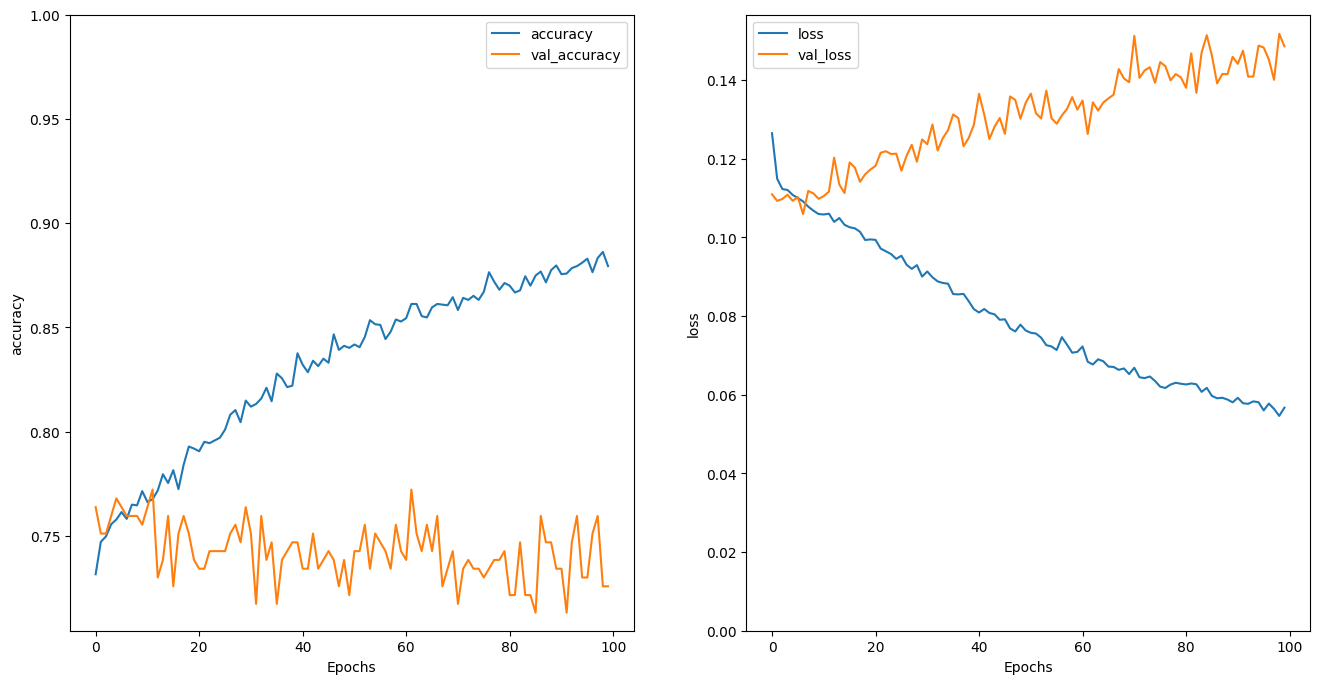

In [1277]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

### evaluate model

In [1278]:
test_features = test_set.copy()
test_labels = pd.concat([test_features.pop(x) for x in CLASSIFICATION_LABELS], axis=1)

In [1279]:
test_loss, test_acc = model.evaluate(test_features,  test_labels, verbose=2)

print('Test Loss:', test_loss)
print('Test accuracy:', test_acc)

45/45 - 0s - loss: 0.1366 - accuracy: 0.7354 - 69ms/epoch - 2ms/step
Test Loss: 0.13664081692695618
Test accuracy: 0.7354385852813721


### predict

In [1280]:
probability_model = tf.keras.Sequential([
    model, 
    tf.keras.layers.Softmax()])

In [1281]:
predictions = probability_model.predict(test_features)

45/45 [==============================] - 0s 993us/step


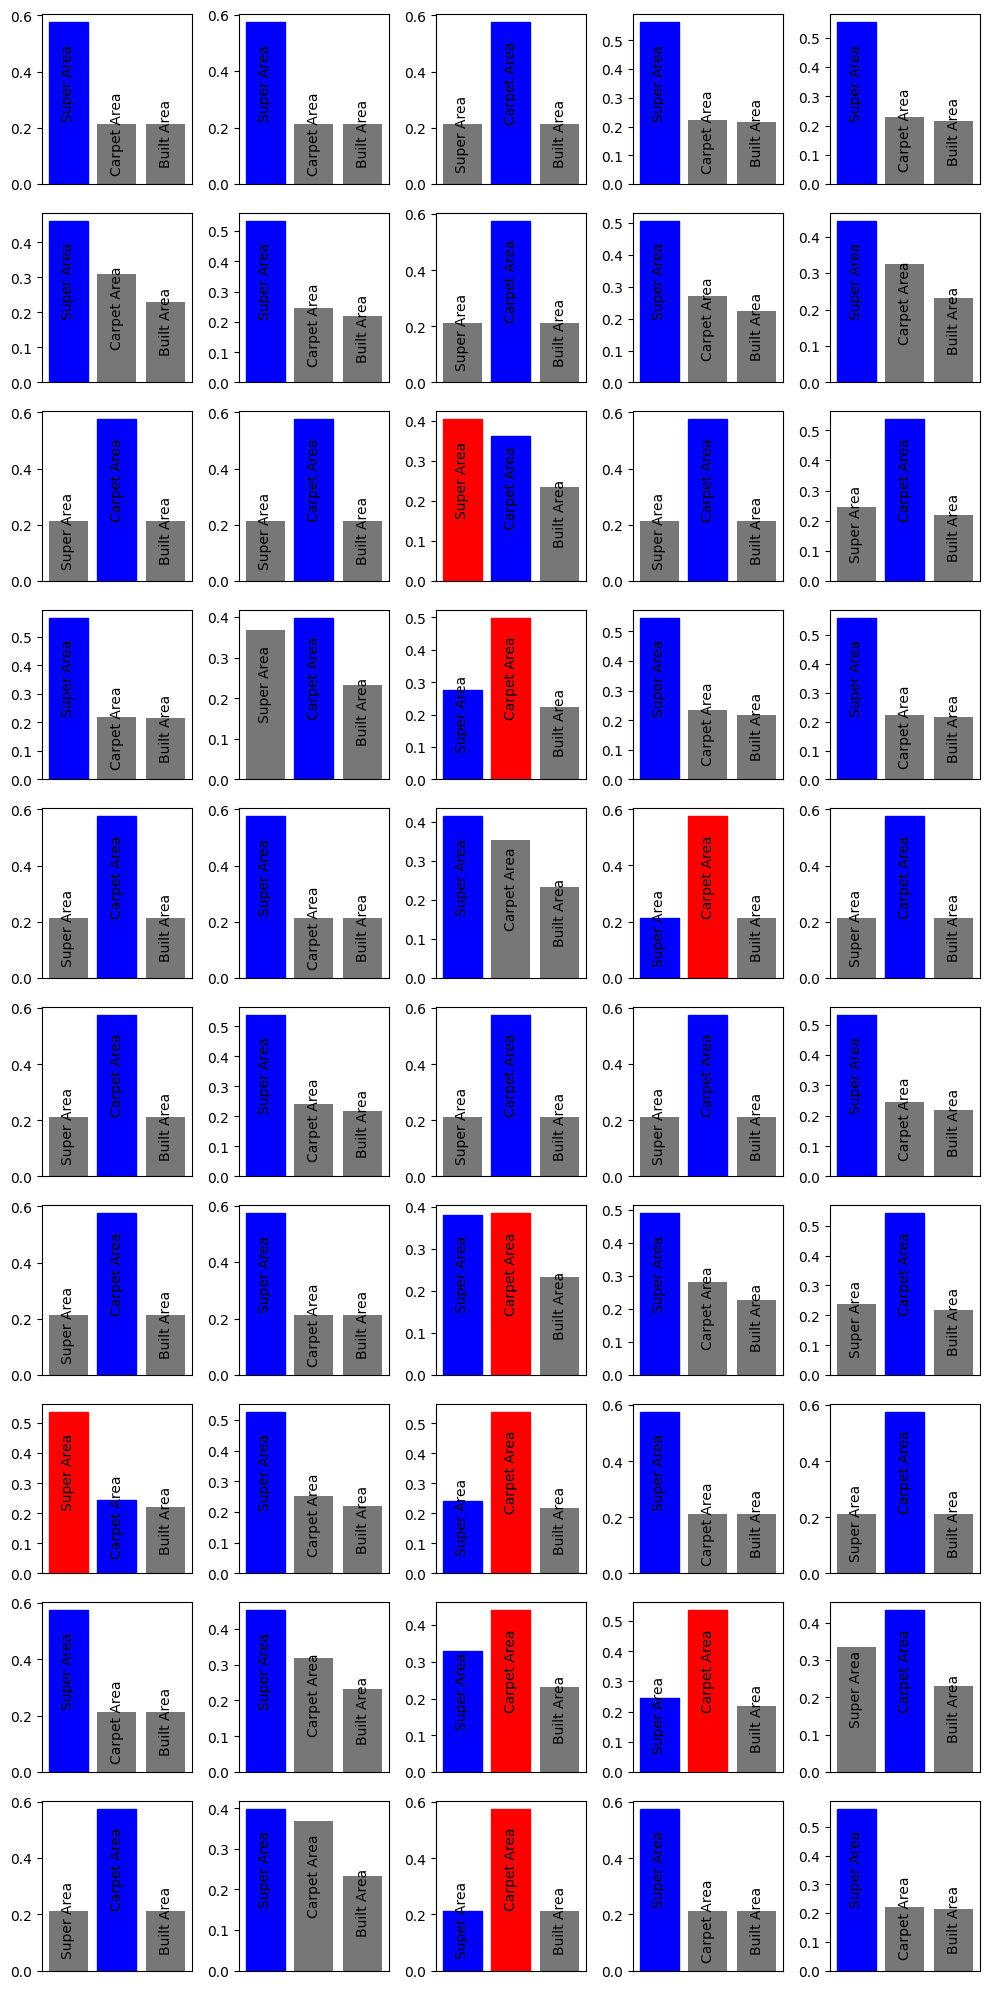

In [1282]:
num_cols = 5
num_rows = 10
num_images = num_rows*num_cols
plt.figure(figsize=(num_cols*2, num_rows*2))
for i in range(num_images):
  ax1 = plt.subplot(num_rows, num_cols, i+1)
  container = plot_value_array(
    i, predictions[i], test_labels.iloc[i])
  ax1.bar_label(
    container,
    labels=CLASSIFICATION_LABELS,
    label_type='center',
    rotation=90,
    padding=15,
    color='black')
plt.tight_layout()
plt.show()

In [1283]:
%tensorboard --logdir logs/

Reusing TensorBoard on port 6008 (pid 91118), started 0:27:11 ago. (Use '!kill 91118' to kill it.)